<a href="https://colab.research.google.com/github/Kimi-Gingercat/Kimi-IAT360-GroupProject/blob/testing/computervisionproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1> <b> Object Detection Using YOLO <b> </h1></center>

This tutorial is designed to provide a comprehensive understanding of how to use YOLO, a state-of-the-art method in computer vision, for detecting objects in images.

Object detection and classification is a key technology in many areas, such as automated vehicles, security, and even healthcare.

We will begin with the basics of preparing (pre processing) an image dataset, ensuring it is ready for effective model training.We will then explore how YOLO, a type of convolutional neural network, automatically extracts features from images to recognize different objects. Understanding this process is crucial for grasping how YOLO operates.

The core of this tutorial is focused on transfer learning using YOLO. We will teach you how to take a pre-trained YOLO model and adapt it to a new dataset. This technique is efficient and powerful, allowing us to harness the strengths of YOLO with less computational effort.

By the end of this tutorial, you will have hands-on experience with preparing data, implementing YOLO, and understanding the principles behind it. This tutorial aims to equip students with practical skills and knowledge in one of the most exciting fields in technology.

Since its inception, the YOLO family of object detection models has come a long way. YOLOv8 is the most recent addition to this famous anchor-based single-shot family of object detectors. It comes with a bunch of improvements which include state-of-the-art accuracy and speed.  In this article, we will be fine tuning the YOLOv8 object detection model on a real-world pothole detection dataset.

In the previous lecture, you were asked to make your own custom datasets for a project you want to work on. Today we will explore how to finetune YOLO on a certain dataset.  

Importing required Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil

After combing with our self-annoted data, there are 580 positive examples in training set and 145 positive examples in testing set.


# Data Preprocessing

For preprocessing:
- We have to convert the dataset into that acceptable by YOLO.
  - Heirarchy of folders should be the one accepted by YOLO
  - Labels format should be darknet YOLO.
  - Labels files should be .txt files
- Check and see if there are any missing labels or images. And remove them from dataset.


## Heirarchy of Folders correction

Defining paths to train and test folders.

In [2]:
test_dir = 'Documents/IAT360/Pothole Assign/PotholeData_2/valid'
train_dir = 'Documents/IAT360/Pothole Assign/PotholeData_2/train'



The train and test folders have all the images and labels together.

But for YOLO, the directories should be in:

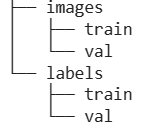


Making directories according to above struture of folders

In [3]:
#import os
#run it once for making directories

#os.makedirs('/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/Final_data')
os.makedirs('Documents/IAT360/Pothole Assign/PotholeData_2/Final_data/images')
os.makedirs('Documents/IAT360/Pothole Assign/PotholeData_2/Final_data/labels')
os.makedirs('Documents/IAT360/Pothole Assign/PotholeData_2/Final_data/images/train')
os.makedirs('Documents/IAT360/Pothole Assign/PotholeData_2/Final_data/images/val')
os.makedirs('Documents/IAT360/Pothole Assign/PotholeData_2/Final_data/labels/train')
os.makedirs('Documents/IAT360/Pothole Assign/PotholeData_2/Final_data/labels/val')

In [4]:
#set the paths to labels and images directory
label_dir= "Documents/IAT360/Pothole Assign/PotholeData_2/Final_data/labels"
image_dir="Documents/IAT360/Pothole Assign/PotholeData_2/Final_data/images"

Copy XML files and jpg files from the train folder to the folders created.

In [5]:
#import shutil
#run it once for copying!
for file in os.listdir(train_dir):
    if file.endswith(".xml"):
        shutil.copy(os.path.join(train_dir, file), os.path.join(label_dir, "train"))
    if file.endswith(".jpg"):
        image = Image.open(os.path.join(train_dir, file))
        image = image.convert("RGB")
        new_filename = os.path.splitext(file)[0] + ".jpg"
        image.save(os.path.join(image_dir,"train", new_filename), "JPEG")
        #shutil.copy(os.path.join(train_dir, file), os.path.join(image_dir, "train"))


#Copy XML files and jpg files from the test folder to the folders created.
for file in os.listdir(test_dir):
    if file.endswith(".xml"):
        shutil.copy(os.path.join(test_dir, file), os.path.join(label_dir, "val"))
    if file.endswith(".jpg"):
        image = Image.open(os.path.join(test_dir, file))
        image = image.convert("RGB")
        new_filename = os.path.splitext(file)[0] + ".jpg"
        image.save(os.path.join(image_dir,"val", new_filename), "JPEG")
        #shutil.copy(os.path.join(test_dir, file), os.path.join(image_dir, "val"))


Visualizing somme pictures from the dataset

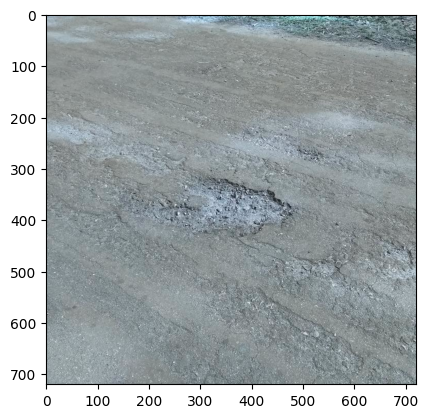

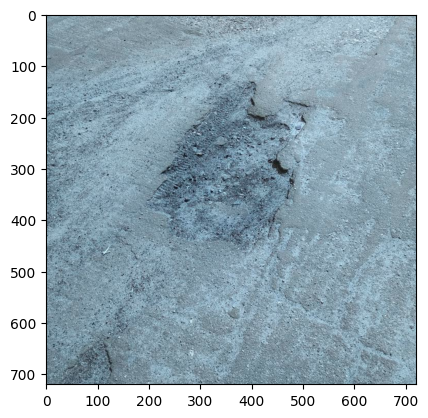

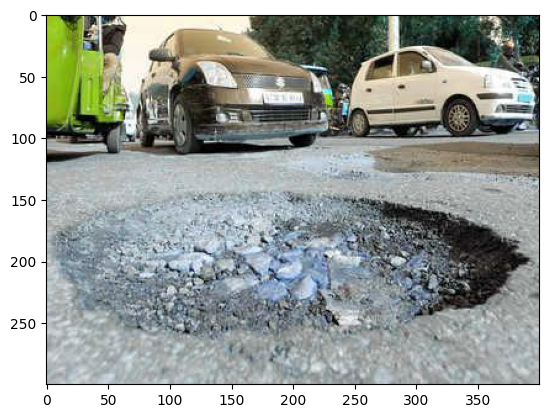

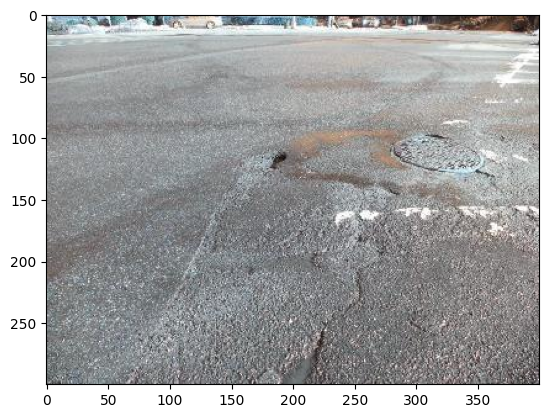

In [6]:
#visualize first four sample images from train data
for idx, image in enumerate(os.listdir(os.path.join(image_dir, "train"))):
    img = cv2.imread(os.path.join(image_dir,"train", image), 1)
    plt.imshow(img)
    plt.show()

    if idx == 3:
        break

## Creating Text files for labels
Creating Dataframes from .xml files, from which we will eventually create .txt file for each image


In [7]:
#import glob
#import xml.etree.ElementTree as ET

df = {'name': [],
      'label': [],
      'width': [],
      'height': [],
     'xmin': [],
     'ymin': [],
     'xmax': [],
     'ymax': []}


#This is the way to handle xml format files which are in heirarchial form (trees).

for idx, anno in enumerate(glob.glob(label_dir+"/train" + '/*.xml')):

    trees = ET.parse(anno)

    print(anno)
    root = trees.getroot()
    width, height = [], []
    for item in root.iter():
        print(item)

        if item.tag == 'size':
            for attr in list(item):
                if attr.tag == 'width':
                    width =int(round(float(attr.text)))
                if attr.tag == 'height':
                    height = int(round(float(attr.text)))

        if item.tag == 'object':
            for attr in list(item):
                if 'name' in attr.tag:
                    label = attr.text
                    df['label'] += [label]
                    df['width'] += [width]
                    df['height'] += [height]
                    df['name'] += [anno.split('/')[-1][0:-4]]

                if 'bndbox' in attr.tag:
                    for dim in attr:
                        if dim.tag == 'xmin':
                            xmin = int(round(float(dim.text)))
                            df['xmin'] += [xmin]

                        if dim.tag == 'ymin':
                            ymin = int(round(float(dim.text)))
                            df['ymin'] += [ymin]
                        if dim.tag == 'xmax':
                            xmax = int(round(float(dim.text)))
                            df['xmax'] += [xmax]
                        if dim.tag == 'ymax':
                            ymax = int(round(float(dim.text)))
                            df['ymax'] += [ymax]

Documents/IAT360/Pothole Assign/PotholeData_2/Final_data/labels/train/img-589.xml
<Element 'annotation' at 0x28c79ec50>
<Element 'folder' at 0x28c79fa60>
<Element 'filename' at 0x28c79fbf0>
<Element 'path' at 0x28c79dfd0>
<Element 'source' at 0x28c79e020>
<Element 'database' at 0x28c79de90>
<Element 'size' at 0x28c79de40>
<Element 'width' at 0x28c79d260>
<Element 'height' at 0x28c79d2b0>
<Element 'depth' at 0x28c79d5d0>
<Element 'segmented' at 0x28c79d620>
<Element 'object' at 0x28c79d670>
<Element 'name' at 0x28c79d6c0>
<Element 'pose' at 0x28c79e610>
<Element 'truncated' at 0x28c79e700>
<Element 'difficult' at 0x28c79e6b0>
<Element 'bndbox' at 0x28c79e7a0>
<Element 'xmin' at 0x28c79df30>
<Element 'ymin' at 0x28c79df80>
<Element 'xmax' at 0x28c79e250>
<Element 'ymax' at 0x28c79e2a0>
<Element 'object' at 0x28c79ee80>
<Element 'name' at 0x28c79e070>
<Element 'pose' at 0x28c79e200>
<Element 'truncated' at 0x28c79e390>
<Element 'difficult' at 0x28c79f740>
<Element 'bndbox' at 0x28c79f3d0>

Doing the same for validation data labels.


In [8]:
#import glob
#import xml.etree.ElementTree as ET

df2 = {'name': [],
      'label': [],
      'width': [],
      'height': [],
     'xmin': [],
     'ymin': [],
     'xmax': [],
     'ymax': []}


#This is the way to handle xml format files which are in heirarchial form (tees).

for idx, anno in enumerate(glob.glob(label_dir+"/val" + '/*.xml')):

    trees = ET.parse(anno)

    #print(anno)
    root = trees.getroot()
    width, height = [], []
    for item in root.iter():
        #print(item)

        if item.tag == 'size':
            for attr in list(item):
                if attr.tag == 'width':
                    width =int(round(float(attr.text)))
                if attr.tag == 'height':
                    height = int(round(float(attr.text)))

        if item.tag == 'object':
            for attr in list(item):
                if 'name' in attr.tag:
                    label = attr.text
                    df2['label'] += [label]
                    df2['width'] += [width]
                    df2['height'] += [height]
                    #dataset['name']+=[anno.split('/')[-1][0:-4]]
                    df2['name'] += [anno.split('/')[-1][0:-4]]

                if 'bndbox' in attr.tag:
                    for dim in attr:
                        if dim.tag == 'xmin':
                            xmin = int(round(float(dim.text)))
                            df2['xmin'] += [xmin]

                        if dim.tag == 'ymin':
                            ymin = int(round(float(dim.text)))
                            df2['ymin'] += [ymin]
                        if dim.tag == 'xmax':
                            xmax = int(round(float(dim.text)))
                            df2['xmax'] += [xmax]
                        if dim.tag == 'ymax':
                            ymax = int(round(float(dim.text)))
                            df2['ymax'] += [ymax]

In [9]:
import pandas as pd
train_df = pd.DataFrame(df)
val_df=pd.DataFrame(df2)
#df1.head()
val_df.head()

name    label  width  height  xmin  ymin  xmax  ymax
0  img-80  pothole    720     720   216   226   449   421
1  img-94  pothole    720     720   180   305   509   426
2  img-43  pothole    720     720   257   115   545   263
3  img-43  pothole    720     720   156   465   328   720
4  img-43  pothole    720     720     0   127    58   207

Visualizing one of the image in train set with the bounding box

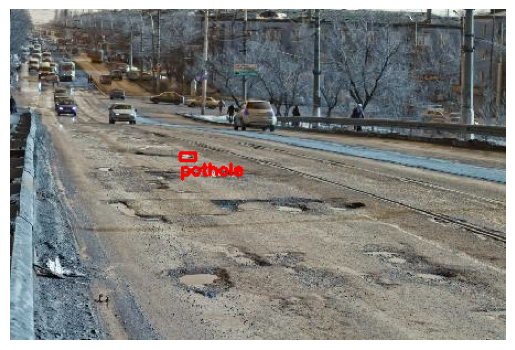

In [10]:
index= 10 #picture to visualize

#import cv2
image = cv2.imread(os.path.join(image_dir,"train", train_df["name"][index]+".jpg"), 1)
# Draw rectangle
cv2.rectangle(image, (train_df['xmin'][index], train_df['ymin'][index]), (train_df['xmax'][index], train_df['ymax'][index]), (255, 0, 0), 2)
# Put label (class_id) near the bbox
label = train_df["label"][index]
cv2.putText(image, str(label), (train_df['xmin'][index], train_df['ymin'][index]+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
# Display image
plt.imshow(image)
plt.axis('off')
plt.show()

Checking to see if the above image has bounding boxes around other apples or not.

In [11]:
train_df["name"][index]
filtered_df = train_df[train_df['name'] == train_df["name"][index]]
print(filtered_df)

       name    label  width  height  xmin  ymin  xmax  ymax
0   img-589  pothole    450     300   141   233   203   262
1   img-589  pothole    450     300   201   219   238   236
2   img-589  pothole    450     300    87   172   147   196
3   img-589  pothole    450     300   181   171   212   185
4   img-589  pothole    450     300   236   175   272   185
5   img-589  pothole    450     300   301   173   323   183
6   img-589  pothole    450     300   231   169   284   177
7   img-589  pothole    450     300   175   142   213   156
8   img-589  pothole    450     300    78   141    94   148
9   img-589  pothole    450     300   123   145   152   157
10  img-589  pothole    450     300   154   130   168   137
11  img-589  pothole    450     300   320   216   408   246


Checking to see the datatypes of all the columns and if there is any null value that needs to be eliminated from the data.

In [12]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    254 non-null    object
 1   label   254 non-null    object
 2   width   254 non-null    int64 
 3   height  254 non-null    int64 
 4   xmin    254 non-null    int64 
 5   ymin    254 non-null    int64 
 6   xmax    254 non-null    int64 
 7   ymax    254 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 16.0+ KB


What different types of labels are assigned to each sample and checking if they match the provided label/class information, i.e. there are no extra labels due to mistakes in spellings etc.

In [13]:
print(train_df['label'].unique())
print(val_df['label'].unique())

['pothole']
['pothole']


We need to map labels to class_ids required for YOLO

In [14]:
label_map = { 'pothole': 0}

train_df['class'] = train_df['label'].map(label_map)
val_df['class'] = val_df['label'].map(label_map)

In [15]:
train_df.head()

name    label  width  height  xmin  ymin  xmax  ymax  class
0  img-589  pothole    450     300   141   233   203   262      0
1  img-589  pothole    450     300   201   219   238   236      0
2  img-589  pothole    450     300    87   172   147   196      0
3  img-589  pothole    450     300   181   171   212   185      0
4  img-589  pothole    450     300   236   175   272   185      0

convertig the bounding box format to the one required by YOLO:




In [17]:
# Training data
train_df['x_center'] = (train_df['xmin']+train_df['xmax'])/(2*train_df["width"])
train_df['y_center'] = (train_df['ymin']+train_df['ymax'])/(2*train_df["height"])
train_df['box_width'] = (train_df['xmax']-train_df['xmin'])/ train_df["width"]
train_df['box_height'] = (train_df['ymax']-train_df['ymin'])/train_df["height"]

#Validation data
val_df['x_center'] = (val_df['xmin']+val_df['xmax'])/(2*val_df["width"])
val_df['y_center'] = (val_df['ymin']+val_df['ymax'])/(2*val_df["height"])
val_df['box_width'] = (val_df['xmax']-val_df['xmin'])/ val_df["width"]
val_df['box_height'] = (val_df['ymax']-val_df['ymin'])/val_df["height"]

In [18]:
train_df.head()

name    label  width  height  xmin  ymin  xmax  ymax  class  x_center  \
0  img-589  pothole    450     300   141   233   203   262      0  0.382222   
1  img-589  pothole    450     300   201   219   238   236      0  0.487778   
2  img-589  pothole    450     300    87   172   147   196      0  0.260000   
3  img-589  pothole    450     300   181   171   212   185      0  0.436667   
4  img-589  pothole    450     300   236   175   272   185      0  0.564444   

   y_center  box_width  box_height  
0  0.825000   0.137778    0.096667  
1  0.758333   0.082222    0.056667  
2  0.613333   0.133333    0.080000  
3  0.593333   0.068889    0.046667  
4  0.600000   0.080000    0.033333

Deleting all the sample with Nan values in training and validation data

In [19]:
#training
print("before deleting (train data): " , train_df.shape)
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
print("after deleting(train_data): " ,train_df.shape)

#validation
print("before deleting (val data): " , val_df.shape)
val_df.replace([np.inf, -np.inf], np.nan, inplace=True)
val_df.dropna(inplace=True)
print("after deleting(val data): " , val_df.shape)



before deleting (train data):  (1486, 13)
after deleting(train_data):  (1486, 13)
before deleting (val data):  (254, 13)
after deleting(val data):  (254, 13)


converting the dataframe to type *str* (string) to be stored in text files.

In [20]:
train_df = train_df.astype(str)
val_df = val_df.astype(str)

If there are more than one bounding boxes in single image, they should be written in one text file. As, you can see in the below example that one image has so many bounding boxes.

In [28]:
filtered_df = train_df[train_df['name'] == train_df["name"][80]]
(filtered_df.head(5))

name    label width height xmin ymin xmax ymax class  \
73  img-577  pothole   480    300   37  154  235  234     0   
74  img-577  pothole   480    300  104  120  141  132     0   
75  img-577  pothole   480    300   35  241   96  300     0   
76  img-577  pothole   480    300  274  194  342  237     0   
77  img-577  pothole   480    300  313  242  354  283     0   

               x_center            y_center            box_width  \
73   0.2833333333333333  0.6466666666666666               0.4125   
74   0.2552083333333333                0.42  0.07708333333333334   
75  0.13645833333333332  0.9016666666666666  0.12708333333333333   
76   0.6416666666666667  0.7183333333333334  0.14166666666666666   
77   0.6947916666666667               0.875  0.08541666666666667   

             box_height  
73  0.26666666666666666  
74                 0.04  
75  0.19666666666666666  
76  0.14333333333333334  
77  0.13666666666666666

In [29]:
#file_name = [x.split('.')[0] for x in df1["name"]]

#TRAINING DATA
#finding all the unique names:
unique_names= train_df['name'].unique()

#for each unique name, containing multiple bboxes, combine them together.
for name in unique_names:
  data = train_df[train_df.name == name]
  box_list = []
  for idx in range(len(data)):
        row = data.iloc[idx]
        box_list.append(row['class']+" "+row['x_center']+" "+row['y_center']+" "+ row['box_width']+" "+row['box_height'])

#writing on text files
  text = "\n".join(box_list)
  with open(f'{label_dir}/train/{name}.txt', 'w') as file:
            file.write(text)
#############################################################################################
#VALIDATION DATA
#finding all the unique names:
unique_names= val_df['name'].unique()

#for each unique name, containing multiple bboxes, combine them together.
for name in unique_names:
  data = val_df[val_df.name == name]
  box_list = []
  for idx in range(len(data)):
        row = data.iloc[idx]
        box_list.append(row['class']+" "+row['x_center']+" "+row['y_center']+" "+ row['box_width']+" "+row['box_height'])

#writing on text files
  text = "\n".join(box_list)
  with open(f'{label_dir}/val/{name}.txt', 'w') as file:
            file.write(text)

## Checking Missing Files

Checking the folders if every image file has a corresponding label file


(We will copy the code, we already used in previous turorial after updating)

In [30]:
#The lists of all the images and labels for train and validation set:
train_images=glob.glob(os.path.join(image_dir, "train",'*.jpg'))
train_labels=glob.glob(os.path.join(label_dir, "train",'*.txt'))
val_images=glob.glob(os.path.join(image_dir, "val",'*.jpg'))
val_labels=glob.glob(os.path.join(label_dir, "val",'*.txt'))
#print(val_labels)

# Get the list of filenames without extensions
image_files_train = {file.split("/")[-1].split(".")[0] for file in train_images}
label_files_train = {file.split("/")[-1].split(".")[0] for file in train_labels}

image_files_val = {file.split("/")[-1].split(".")[0] for file in val_images}
label_files_val = {file.split("/")[-1].split(".")[0] for file in val_labels}
#print(image_files_val)



In [31]:
print(len(image_files_val), "  =  ", len(label_files_val))

133   =   133


In [32]:
# Find extra files in each folder

#TRAINING DATA
extra_images_train = image_files_train - label_files_train
extra_labels_train = label_files_train - image_files_train

# Output the results
print(f"Training Extra images (without corresponding labels): {extra_images_train}")
print(f"Training Extra labels (without corresponding images): {extra_labels_train}")


#VALIDATION DATA
extra_images_val = image_files_val - label_files_val
extra_labels_val = label_files_val - image_files_val

# Output the results
print(f"Validation Extra images (without corresponding labels): {extra_images_val}")
print(f"Validation Extra labels (without corresponding images): {extra_labels_val}")

Training Extra images (without corresponding labels): set()
Training Extra labels (without corresponding images): set()
Validation Extra images (without corresponding labels): set()
Validation Extra labels (without corresponding images): set()


Make sure that the above info is correct by chceking the data manually.

Now removing from the dataset:

In [33]:
for file in extra_images_train:
     os.remove(os.path.join(image_dir, "train", file + '.jpg')) # or '.png' depending on your image format

for file in extra_images_val:
     os.remove(os.path.join(image_dir, "val", file + '.jpg'))

Now run the above cells again to find if all the missing data is deleted.

# Custom object detection using YOLO

First install and import

In [34]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.27 🚀 Python-3.12.6 torch-2.5.1 CPU (Apple M3 Pro)
Setup complete ✅ (11 CPUs, 18.0 GB RAM, 218.9/926.4 GB disk)


In [35]:
from ultralytics import YOLO

## Training YOLO

We are going to select small pretrained (on COCO dataset) model of YOLOv8

In [36]:
model = YOLO('yolov8s.pt') # pretrained model

The detailed architecture of the model can be seen from:


In [37]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

In [94]:
%%writefile config.yaml
path: /Users/kimi/Documents/IAT360/Pothole Assign/PotholeData_2/Final_data
train: /Users/kimi/Documents/IAT360/Pothole Assign/PotholeData_2/Final_data/images/train
#test: (test dataset folder path)
val: /Users/kimi/Documents/IAT360/Pothole Assign/PotholeData_2/Final_data/images/val

# Classes
nc: 1 # replace based on your dataset's number of classes

# Class names
# replace all class names with your own classes' names
names:
  0: pothole

Overwriting config.yaml


In [95]:
import os

config_path = os.path.abspath("config.yaml")
print("Path to config.yaml:", config_path)


Path to config.yaml: /Users/kimi/config.yaml


Please look at [Yolo train Docs](https://docs.ultralytics.com/modes/train/#train-settings) for hyperparameters for model tuning and configuration, e.g. lr0, imgsz, model etc.

In [96]:
model.train(data="config.yaml",epochs=5,patience=5,batch=8, lr0=0.0005,imgsz=640)

Ultralytics 8.3.27 🚀 Python-3.12.6 torch-2.5.1 CPU (Apple M3 Pro)
engine/trainer: task=detect, mode=train, model=runs/detect/train11/weights/best.pt, data=config.yaml, epochs=5, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=0, project=None, name=train1233, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True,

train: Scanning /Users/kimi/Documents/IAT360/Pothole Assign/PotholeData_2/Final_


train: New cache created: /Users/kimi/Documents/IAT360/Pothole Assign/PotholeData_2/Final_data/labels/train.cache


val: Scanning /Users/kimi/Documents/IAT360/Pothole Assign/PotholeData_2/Final_da

val: New cache created: /Users/kimi/Documents/IAT360/Pothole Assign/PotholeData_2/Final_data/labels/val.cache
Plotting labels to runs/detect/train1233/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train1233
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      1.335      1.181      1.361         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        145        272      0.719      0.641       0.73      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G      1.383      1.218      1.392         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        145        272      0.768       0.61      0.728      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      1.348      1.183       1.36         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        145        272      0.731      0.679      0.737       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G      1.354      1.178      1.385          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        145        272      0.762      0.647      0.746      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G      1.297       1.13      1.355         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        145        272      0.669      0.765      0.777        0.5



5 epochs completed in 0.389 hours.
Optimizer stripped from runs/detect/train1233/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train1233/weights/best.pt, 22.5MB

Validating runs/detect/train1233/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.12.6 torch-2.5.1 CPU (Apple M3 Pro)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        145        272       0.67      0.762      0.777      0.499
Speed: 0.7ms preprocess, 294.0ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/train1233


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x301839fa0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048,    

## Evaluation Metrics

[This](https://docs.ultralytics.com/guides/yolo-performance-metrics/) is a very good detailed explanation of different perfromance metrics in YOLO.

**Choosing the Right Metrics**

Choosing the right metrics to evaluate often depends on the specific application.

- mAP: Suitable for a broad assessment of model performance.

- IoU: Essential when precise object location is crucial.

- Precision: Important when minimizing false detections is a priority.

- Recall: Vital when it's important to detect every instance of an object.

- F1 Score: Useful when a balance between precision and recall is needed.


In [105]:
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category
metrics.box.mp    # P
metrics.box.mr    # R

Ultralytics 8.3.27 🚀 Python-3.12.6 torch-2.5.1 CPU (Apple M3 Pro)


val: Scanning /Users/kimi/Documents/IAT360/Pothole Assign/PotholeData_2/Final_da
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        145        272       0.67      0.762      0.777      0.499
Speed: 0.6ms preprocess, 118.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/train12335


0.7620793588643264

In [78]:
# Assuming you have already initialized and started training your model
print("Training outputs saved to:", model.trainer.save_dir)


Training outputs saved to: runs/detect/train12


Showing confusion matrix, that is already stored in detect/train folder

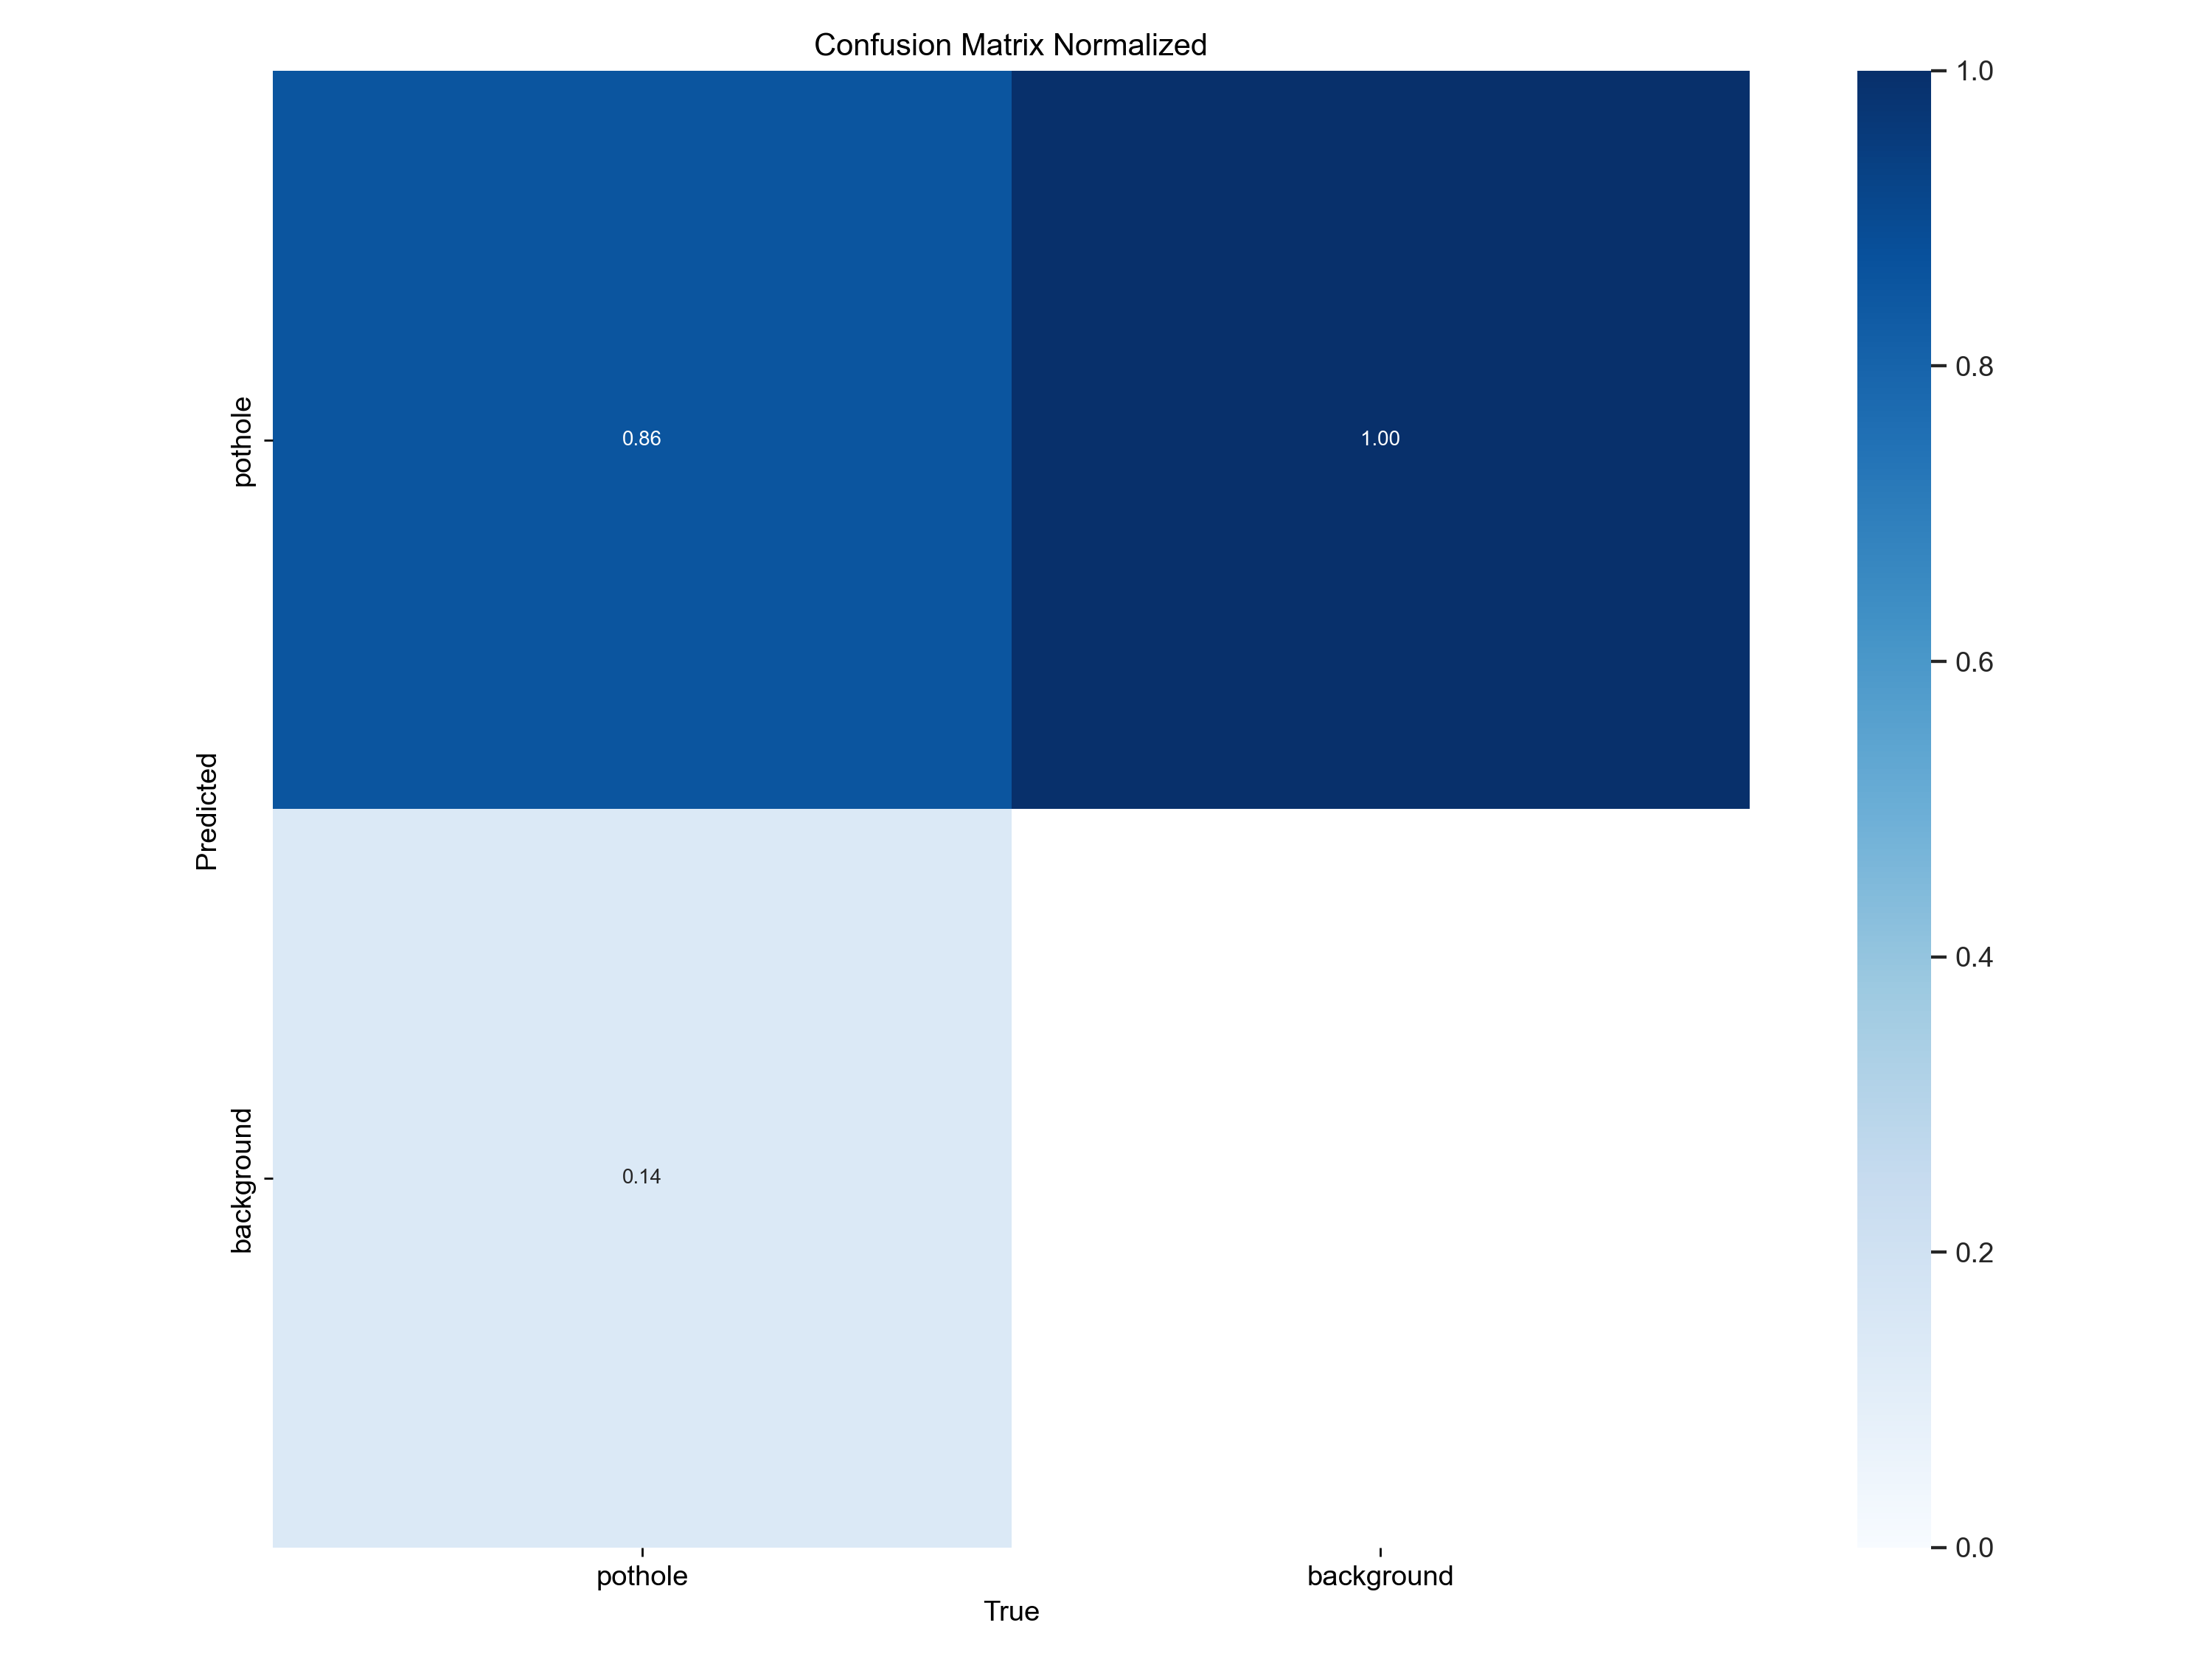

In [106]:
%matplotlib inline
from PIL import Image

Image.open('runs/detect/train12335/confusion_matrix_normalized.png')

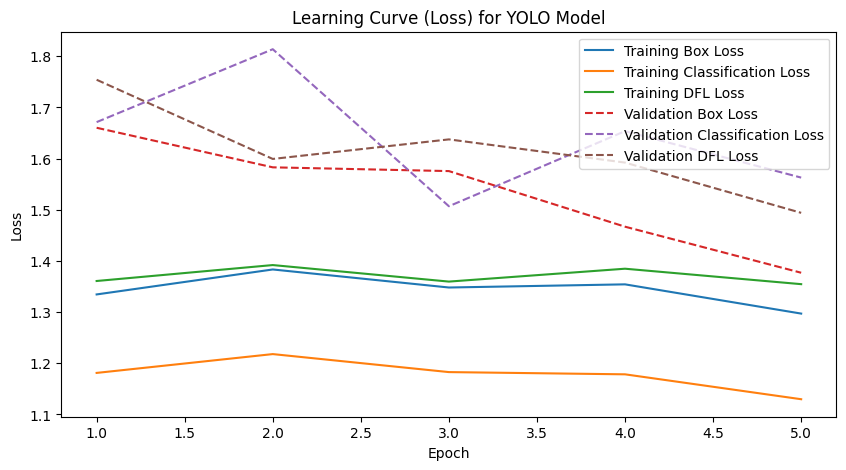

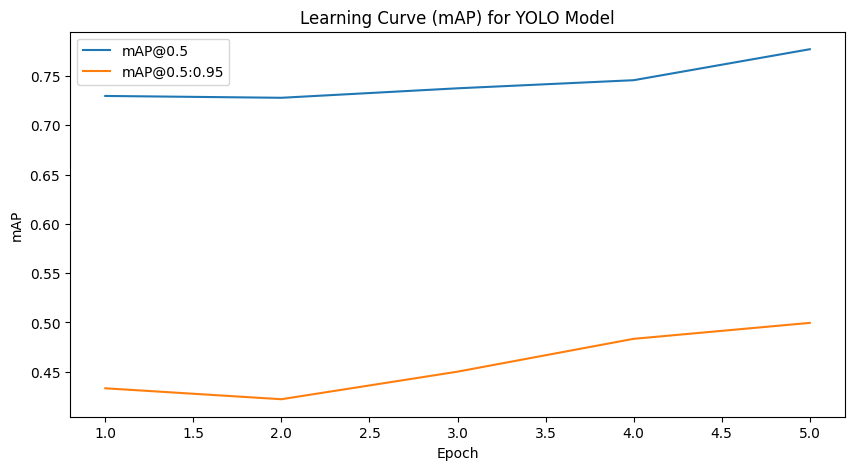

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Replace with the actual path to your training results directory
results_path = 'runs/detect/train1233/results.csv'

# Load training metrics
results = pd.read_csv(results_path)



# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(results['epoch'], results['train/box_loss'], label='Training Box Loss')
plt.plot(results['epoch'], results['train/cls_loss'], label='Training Classification Loss')
plt.plot(results['epoch'], results['train/dfl_loss'], label='Training DFL Loss')
plt.plot(results['epoch'], results['val/box_loss'], label='Validation Box Loss', linestyle='--')
plt.plot(results['epoch'], results['val/cls_loss'], label='Validation Classification Loss', linestyle='--')
plt.plot(results['epoch'], results['val/dfl_loss'], label='Validation DFL Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve (Loss) for YOLO Model')
plt.legend()
plt.show()

# Plot mAP over epochs
plt.figure(figsize=(10, 5))
plt.plot(results['epoch'], results['metrics/mAP50(B)'], label='mAP@0.5')
plt.plot(results['epoch'], results['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('Learning Curve (mAP) for YOLO Model')
plt.legend()
plt.show()



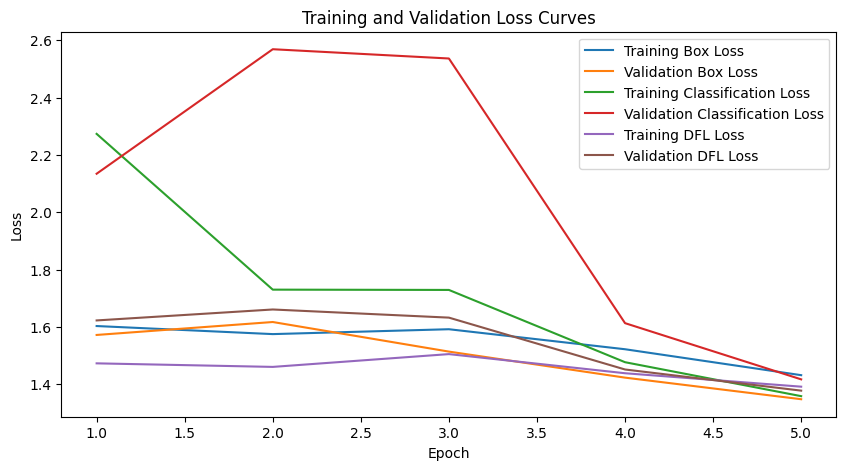

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Path to the results CSV file
results_path = "runs/detect/train11/results.csv"  # Replace with your specific path

# Load the training log data
results = pd.read_csv(results_path)


# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(results['epoch'], results['train/box_loss'], label='Training Box Loss')
plt.plot(results['epoch'], results['val/box_loss'], label='Validation Box Loss')
plt.plot(results['epoch'], results['train/cls_loss'], label='Training Classification Loss')
plt.plot(results['epoch'], results['val/cls_loss'], label='Validation Classification Loss')
plt.plot(results['epoch'], results['train/dfl_loss'], label='Training DFL Loss')
plt.plot(results['epoch'], results['val/dfl_loss'], label='Validation DFL Loss')

# Customize the plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend(loc="best")
plt.show()



##Prediction

In [69]:
#model = YOLO()  # load a custom model
from ultralytics import YOLO

# Load the trained model weights (change trainX to the correct folder number, e.g., train112)
trained_model_path = "runs/detect/train11/weights/best.pt"  # Use 'last.pt' if needed
model = YOLO(trained_model_path)  # Load your trained model

# Now you can use this model for inference or further evaluation


# Predict with the model with any image from internet?
results = model('https://www.pavementinteractive.org/wp-content/uploads/2007/08/Kailua_pothole.jpg',imgsz=640,save=True)


⚠️ Download failure, retrying 1/3 https://www.pavementinteractive.org/wp-content/uploads/2007/08/Kailua_pothole.jpg...
image 1/1 /Users/kimi/Kailua_pothole.jpg: 480x640 3 potholes, 95.6ms
Speed: 1.2ms preprocess, 95.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict14


######################################################################## 100.0%


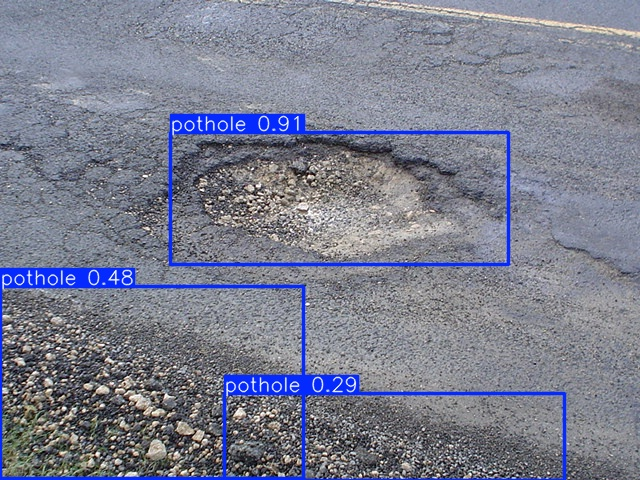

In [70]:
# SHOW THE IMAGE STORED
%matplotlib inline
from PIL import Image

Image.open('runs/detect/predict14/Kailua_pothole.jpg')